<a href="https://colab.research.google.com/github/jonathan-arevalo/Data-Analysis-Portfolio/blob/main/HealthInPeru_Malaria%26Dengue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dengue & malaria, one of the biggest fears of Peru.

This study analyzes the evolution of dengue in Peru from 2000 to 2024, leveraging big data to identify trends, incidence peaks, and factors associated with case increases across various regions. Through the creation of interactive dashboards and visualizations, the research highlights the geographic and temporal distribution of dengue cases, emphasizing critical years and the most affected areas. This analysis provides a comprehensive view of epidemiological patterns, offering key insights to guide future prevention and control strategies.

---

Este estudio analiza la evolución del dengue en Perú desde el año 2000 hasta el 2024, utilizando datos masivos para identificar tendencias, picos de incidencia y factores asociados al aumento de casos en distintas regiones. Se busca visualizar la distribución geográfica y temporal de los casos de dengue, resaltando los años críticos y las regiones más afectadas. Este análisis ofrece una visión integral de los patrones epidemiológicos, ayudando a comprender las dinámicas de la enfermedad y proporcionando información clave para la formulación de estrategias de prevención y control en el futuro.

**Indice de datos/ Dataset Variables**
--

| Campo         | Tipo      | Denominación                      | Valores                                 |
|---------------|-----------|------------------------------------|-----------------------------------------|
| departamento  | caracter  | región geográfica                 |                                         |
| provincia     | caracter  | provincia                         |                                         |
| distrito      | caracter  | lugar probable de infección       |                                         |
| enfermedad    | caracter  | diagnóstico vigilado              |                                         |
| ano           | integer   | año                               |                                         |
| semana        | caracter  | semana de inicio de síntomas      |                                         |
| diagnostic    | caracter  | CIE10                             |                                         |
| tipo_dx       | caracter  | tipo de diagnóstico               | c=confirmado, p=probable, s=sospechoso |
| diresa        | caracter  | dirección de salud que notifica   |                                         |
| ubigeo        | caracter  | código del lugar probable         |                                         |
| edad          | caracter  | edad del paciente                 |                                         |
| tipo_edad     | caracter  | tipo de edad del paciente         | a=año, m=mes, d=días                   |
| sexo          | caracter  | sexo                              | m=masculino, f=femenino                |


| Field          | Type      | Description                        | Values                                 |
|----------------|-----------|------------------------------------|-----------------------------------------|
| department     | character | geographic region                 |                                         |
| province       | character | province                          |                                         |
| district       | character | probable place of infection       |                                         |
| disease        | character | monitored diagnosis               |                                         |
| year           | integer   | year                              |                                         |
| week           | character | symptom onset week                |                                         |
| diagnostic     | character | CIE10                             |                                         |
| diagnosis_type | character | type of diagnosis                 | c=confirmed, p=probable, s=suspected   |
| health_dir     | character | reporting health directorate      |                                         |
| location_code  | character | probable place code               |                                         |
| age            | character | patient's age                     |                                         |
| age_type       | character | patient's age type                | y=year, m=month, d=day                 |
| sex            | character | sex                               | m=male, f=female                       |

In [ ]:
!pip install pyspark
!pip install streamlit

import streamlit as st
import seaborn as sns
import plotly.express as px
import streamlit as st
import pyspark
import folium
from sklearn.linear_model import LinearRegression
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
#from pyspark.sql.functions import "variables"
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.3 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
#importar y crear la sesion
spark = SparkSession.builder.appName("Analisis de enfermedades").getOrCreate()

google_sheets_url = "https://drive.google.com/uc?id=1Wmao2DAmFzHIs-Ae-ZJPP5KGvkn0eoz_&export=download"
dengue_df = pd.read_csv(google_sheets_url)
dengue_spark_df = spark.createDataFrame(dengue_df)

def spark_to_pandas(spark_df):
    return spark_df.toPandas()

In [ ]:
#interactive table to understand the data
from google.colab import data_table

dengue_pandas_df = spark_to_pandas(dengue_spark_df)
spark_to_pandas(dengue_spark_df)

data_table.DataTable(dengue_pandas_df, include_index=False, num_rows_per_page=10)

In [ ]:
#Cleaning
dengue_spark_df = dengue_spark_df.na.drop()

categorical_columns = ['departamento', 'provincia', 'distrito', 'enfermedad', 'diagnostic', 'tipo_dx', 'diresa', 'ubigeo', 'tipo_edad', 'sexo']
numeric_columns = ['ano', 'semana', 'edad']

for col in categorical_columns:
    dengue_spark_df = dengue_spark_df.fillna("Desconocido", subset=[col])

#nullcol droping 0
for col in numeric_columns:
    dengue_spark_df = dengue_spark_df.fillna(0, subset=[col])

#numcol to int
for col in numeric_columns:
    dengue_spark_df = dengue_spark_df.withColumn(col, dengue_spark_df[col].cast(IntegerType()))

#SOLO rangos logicos
dengue_spark_df = dengue_spark_df.filter((F.col("ano") >= 2000) & (F.col("ano") <= 2024))
dengue_spark_df = dengue_spark_df.filter((F.col("semana") >= 1) & (F.col("semana") <= 52))
dengue_spark_df = dengue_spark_df.filter((F.col("edad") >= 0) & (F.col("edad") <= 120))

#dropear duplicados
dengue_spark_df = dengue_spark_df.dropDuplicates()

#filtrar valores validos
dengue_spark_df = dengue_spark_df.filter(F.col("tipo_dx").isin("C", "P")) #omitimos 'S' debido a que no existen entradas con este valor
dengue_spark_df = dengue_spark_df.filter(F.col("sexo").isin("M", "F"))
dengue_spark_df = dengue_spark_df.filter(F.col("tipo_edad").isin("A", "M", "D"))

#excluir valores categóricos incorrectos en 'departamento'
dengue_spark_df = dengue_spark_df.filter(F.col("departamento") != "Desconocido")
dengue_spark_df = dengue_spark_df.filter(F.col("provincia") != "Desconocido")
dengue_spark_df = dengue_spark_df.filter(F.col("distrito") != "Desconocido")


dengue_pandas_df = dengue_spark_df.toPandas()
print('Cleaning done! May proceed with caution')

Cleaning done! May proceed with caution


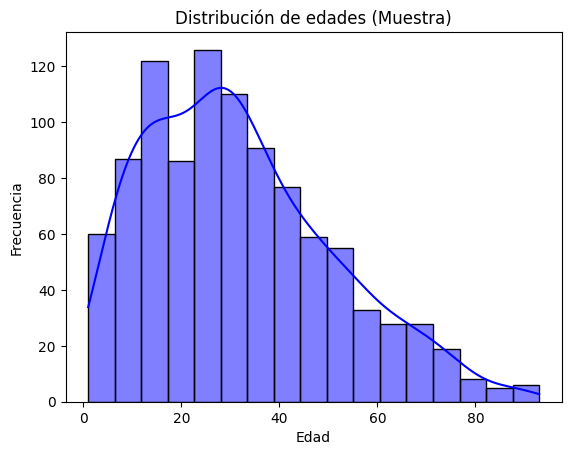

In [ ]:
muestra = dengue_pandas_df.sample(1000, random_state=42)

sns.histplot(muestra['edad'], kde=True, color='blue')
plt.title('Distribución de edades (Muestra)')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

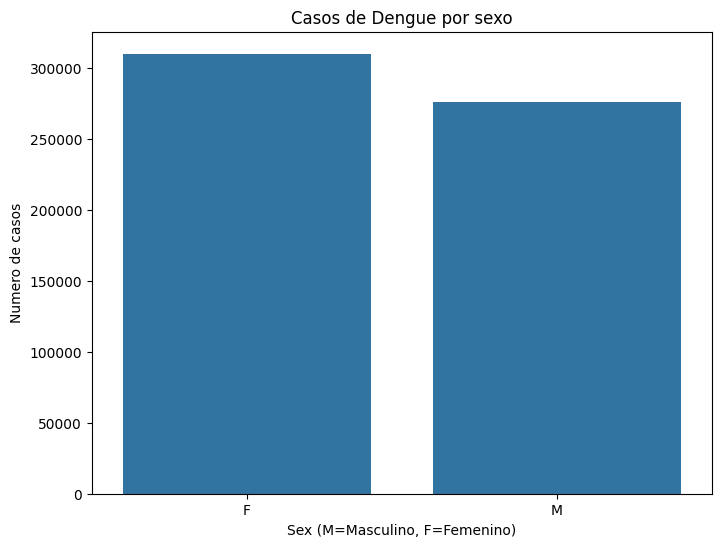

In [ ]:
sex_counts = dengue_pandas_df['sexo'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sex_counts.index, y=sex_counts.values)
plt.title('Casos de Dengue por sexo')
plt.xlabel('Sex (M=Masculino, F=Femenino)')
plt.ylabel('Numero de casos')
plt.show()

In [ ]:
# Top 10 departamentos con más casos (independientemente del estado del caso)
casos_departamento = dengue_pandas_df['departamento'].value_counts().head(10).reset_index()
casos_departamento.columns = ['Departamento', 'Casos']

fig = px.bar(
    casos_departamento,
    x='Departamento',
    y='Casos',
    title='Top 10 departamentos con más casos de todos los años',
    color='Casos',
    labels={'Casos': 'Número de casos'}
)
fig.show()

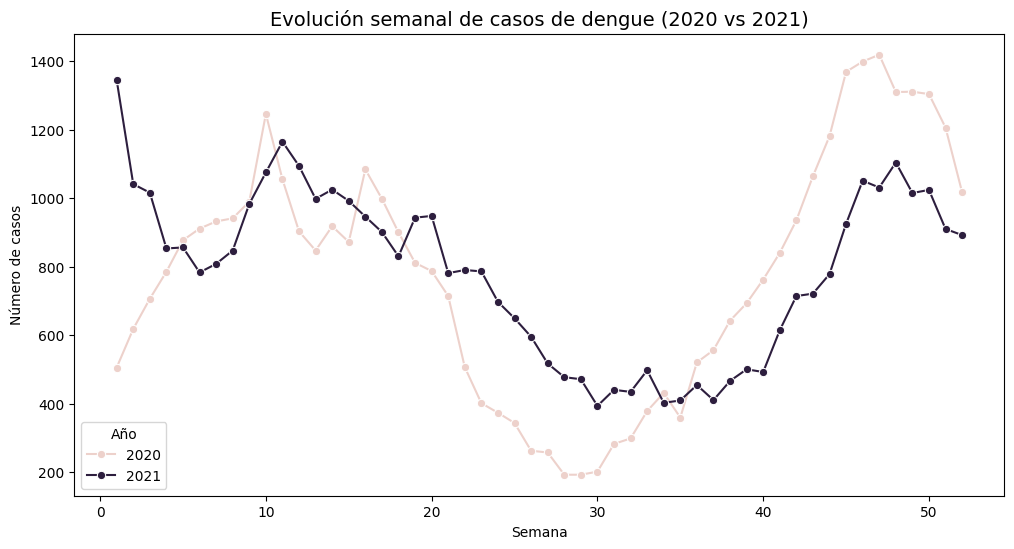

In [ ]:
#evolucion semanal de casos de dengue
filtro_anos = dengue_pandas_df[(dengue_pandas_df['ano'] == 2020) | (dengue_pandas_df['ano'] == 2023)]
evolucion_casos = filtro_anos.groupby(['ano', 'semana']).size().reset_index(name='casos')

plt.figure(figsize=(12, 6))
sns.lineplot(data=evolucion_casos, x='semana', y='casos', hue='ano', marker='o')
plt.title('Evolución semanal de casos de dengue (2020 vs 2021)', fontsize=14)
plt.xlabel('Semana')
plt.ylabel('Número de casos')
plt.legend(title='Año')
plt.show()

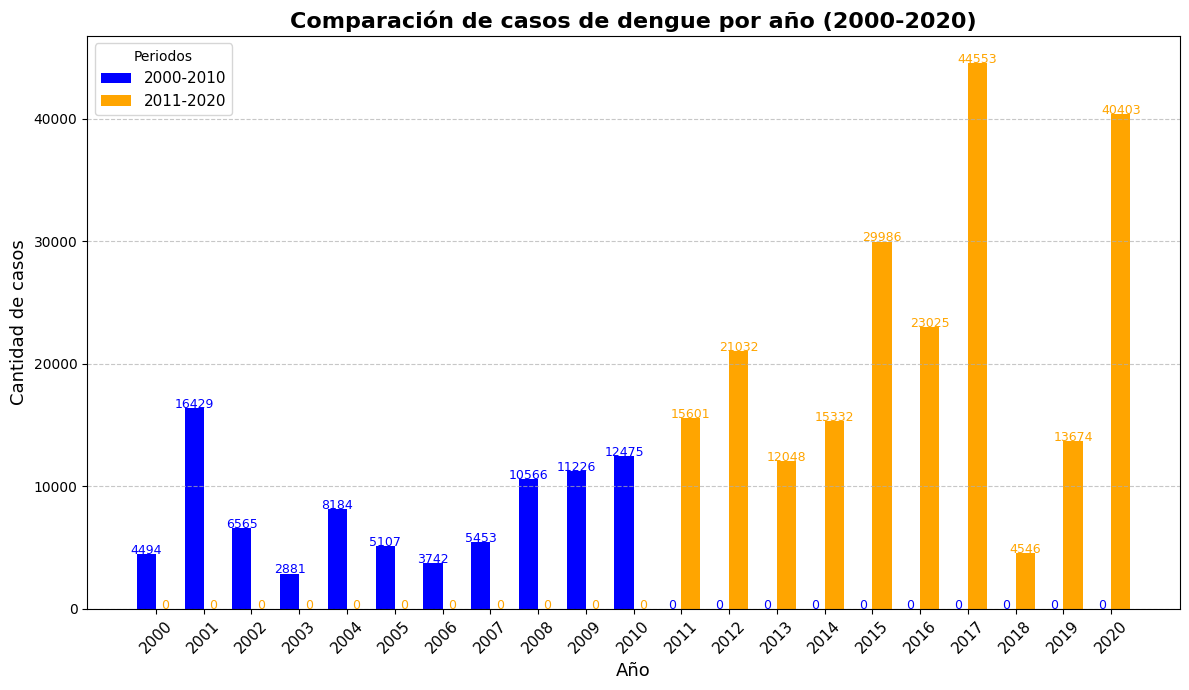

In [ ]:
periodo_1 = dengue_pandas_df[(dengue_pandas_df['ano'] >= 2000) & (dengue_pandas_df['ano'] <= 2010)]
periodo_2 = dengue_pandas_df[(dengue_pandas_df['ano'] >= 2011) & (dengue_pandas_df['ano'] <= 2020)]

casos_periodo_1 = periodo_1.groupby('ano').size()
casos_periodo_2 = periodo_2.groupby('ano').size()

#periodos
anos = sorted(list(set(casos_periodo_1.index).union(set(casos_periodo_2.index))))
casos_periodo_1 = casos_periodo_1.reindex(anos, fill_value=0)
casos_periodo_2 = casos_periodo_2.reindex(anos, fill_value=0)

x = np.arange(len(anos))
width = 0.4

fig, ax = plt.subplots(figsize=(12, 7))


ax.bar(x - width / 2, casos_periodo_1, width, color='blue', label='2000-2010')
ax.bar(x + width / 2, casos_periodo_2, width, color='orange', label='2011-2020')
ax.set_title('Comparación de casos de dengue por año (2000-2020)', fontsize=16, fontweight='bold')
ax.set_xlabel('Año', fontsize=13)
ax.set_ylabel('Cantidad de casos', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(anos, rotation=45, fontsize=11)
ax.legend(title="Periodos", fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.7)

for i, (v1, v2) in enumerate(zip(casos_periodo_1, casos_periodo_2)):
    ax.text(x[i] - width / 2, v1 + 5, str(v1), ha='center', fontsize=9, color='blue')
    ax.text(x[i] + width / 2, v2 + 5, str(v2), ha='center', fontsize=9, color='orange')

plt.tight_layout()
plt.show()

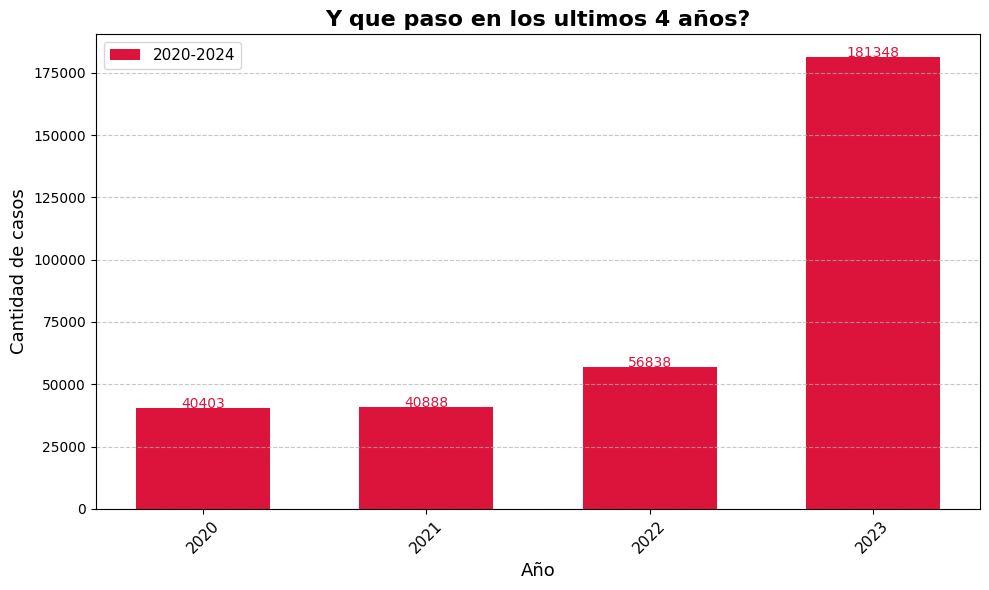

In [ ]:
periodo = dengue_pandas_df[(dengue_pandas_df['ano'] >= 2020) & (dengue_pandas_df['ano'] <= 2024)]

casos_periodo = periodo.groupby('ano').size()

anos = casos_periodo.index
x = np.arange(len(anos))
width = 0.6

fig, ax = plt.subplots(figsize=(10, 6))


ax.bar(x, casos_periodo, width, color='crimson', label='2020-2024')


ax.set_title('Y que paso en los ultimos 4 años?', fontsize=16, fontweight='bold')
ax.set_xlabel('Año', fontsize=13)
ax.set_ylabel('Cantidad de casos', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(anos, rotation=45, fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(casos_periodo):
    ax.text(x[i], v + 5, str(v), ha='center', fontsize=10, color='crimson')

plt.tight_layout()
plt.show()


<ipython-input-36-52170dcf43e9>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




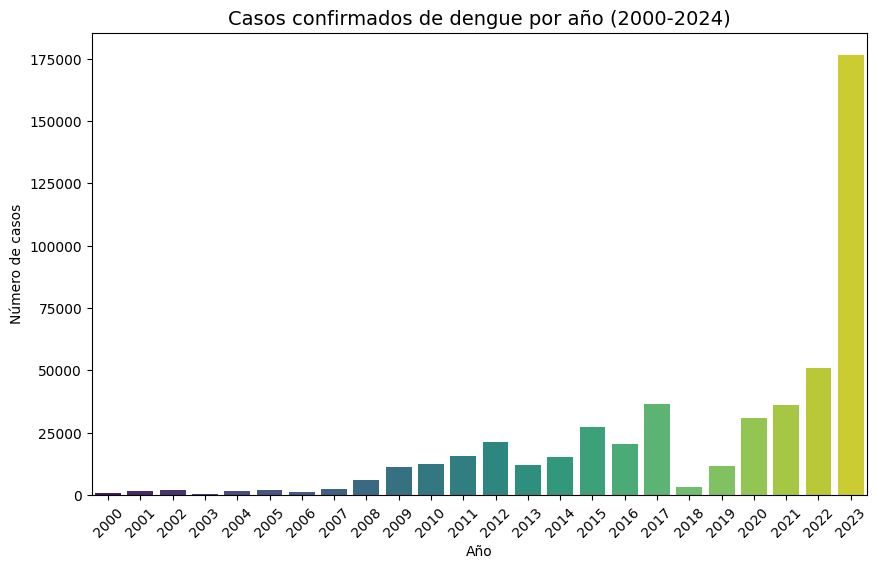

In [ ]:
#Casos confirmados de dengue por año
dengue_confirmados = dengue_pandas_df[dengue_pandas_df['tipo_dx'] == 'C']

casos_por_ano = dengue_confirmados.groupby('ano').size().reset_index(name='casos')

plt.figure(figsize=(10, 6))
sns.barplot(data=casos_por_ano, x='ano', y='casos', palette='viridis')
plt.title('Casos confirmados de dengue por año (2000-2024)', fontsize=14)
plt.xlabel('Año')
plt.ylabel('Número de casos')
plt.xticks(rotation=45)
plt.show()

In [ ]:
3#heatmap cambiar por lugar, buscar como automatizar sin usar coordenadas
from folium.plugins import HeatMap

dengue_2020 = dengue_pandas_df[dengue_pandas_df['ano'] == 2020]
departamento_counts_2020 = dengue_2020.groupby('departamento').size().reset_index(name='Casos')

departamento_coords = {
    'AMAZONAS': [-5.0739, -78.0433],
    'ANCASH': [-9.5284, -77.5289],
    'APURIMAC': [-13.6365, -72.8813],
    'AREQUIPA': [-16.4090, -71.5375],
    'AYACUCHO': [-13.1588, -74.2236],
    'CAJAMARCA': [-7.1617, -78.5003],
    'CALLAO': [-12.0566, -77.1181],
    'CUSCO': [-13.5319, -71.9675],
    'HUANCAVELICA': [-12.7870, -74.9712],
    'HUANUCO': [-9.9306, -76.2422],
    'ICA': [-14.0678, -75.7286],
    'JUNIN': [-11.1580, -75.9996],
    'LA LIBERTAD': [-8.1117, -79.0288],
    'LAMBAYEQUE': [-6.7714, -79.8409],
    'LIMA': [-12.0464, -77.0428],
    'LORETO': [-3.7491, -73.2538],
    'MADRE DE DIOS': [-12.5933, -69.1895],
    'MOQUEGUA': [-17.1941, -70.9329],
    'PASCO': [-10.6844, -76.2569],
    'PIURA': [-5.1945, -80.6328],
    'PUNO': [-15.8402, -70.0219],
    'SAN MARTIN': [-6.5120, -76.4328],
    'TACNA': [-18.0127, -70.2533],
    'TUMBES': [-3.5669, -80.4515],
    'UCAYALI': [-8.3792, -74.5539]
}

m = folium.Map(location=[-9.1900, -75.0152], zoom_start=5)
heat_data = []

for index, row in departamento_counts_2020.iterrows():
    departamento = row['departamento']
    casos = row['Casos']
    if departamento in departamento_coords:
        latitude, longitude = departamento_coords[departamento]
        heat_data.append([latitude, longitude, casos])
if heat_data:
    HeatMap(heat_data, radius=15, blur=10, max_zoom=10).add_to(m)

m

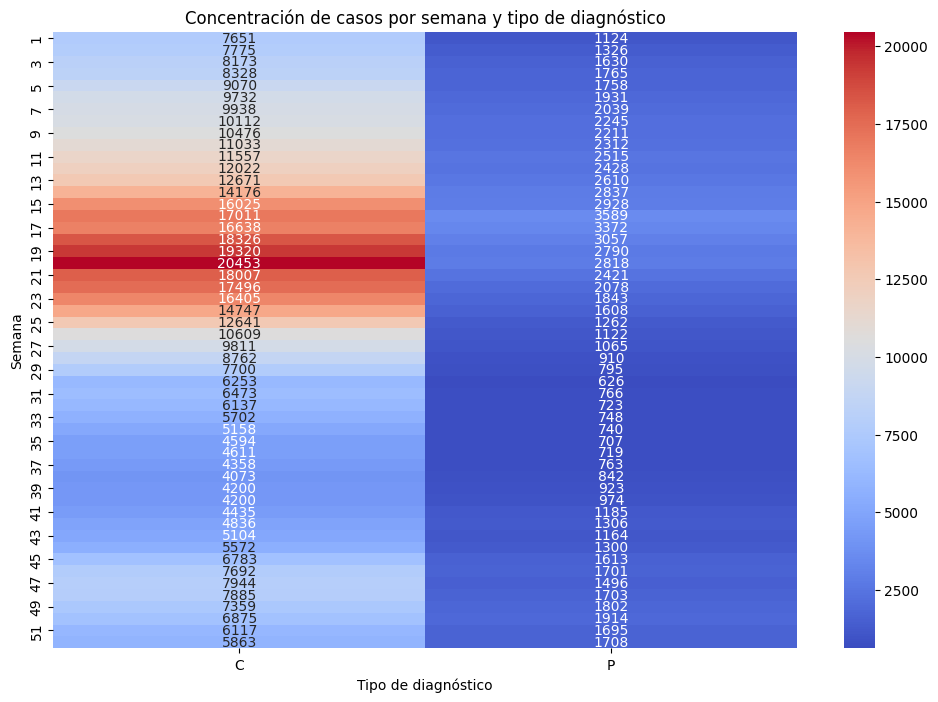

In [ ]:
# Crear tabla pivote para el heatmap
heatmap_data = dengue_pandas_df.pivot_table(index='semana', columns='tipo_dx', aggfunc='size', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='d')
plt.title('Concentración de casos por semana y tipo de diagnóstico')
plt.xlabel('Tipo de diagnóstico')
plt.ylabel('Semana')
plt.show()

In [ ]:
#filtro 2020 y 2024
dengue_filtrado = dengue_pandas_df[(dengue_pandas_df['ano'] >= 2020) & (dengue_pandas_df['ano'] <= 2024)]

dengue_filtrado = dengue_filtrado[dengue_filtrado['tipo_dx'].isin(['C', 'P', 'S'])]

tipo_diagnostico_filtrado = dengue_filtrado['tipo_dx'].value_counts()

colores = {
    'C': 'blue',  #confirmado
    'P': 'orange',  #probable
    'S': 'green'   #sospechoso
}

fig = px.pie(
    values=tipo_diagnostico_filtrado.values,
    names=tipo_diagnostico_filtrado.index,
    title='Distribución de Tipos de Diagnóstico de Dengue (2020-2024)',
    color=tipo_diagnostico_filtrado.index,
    color_discrete_map=colores,
    width=700,
    height=500
)
fig.update_traces(textinfo='percent+label')

fig.show()

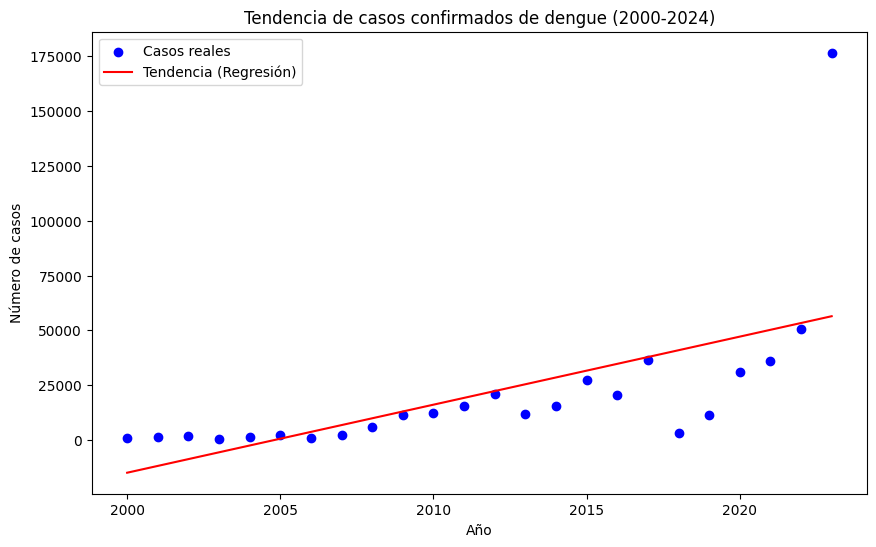

In [ ]:
from sklearn.linear_model import LinearRegression

regresion_data = dengue_confirmados.groupby('ano').size().reset_index(name='casos')
X = regresion_data['ano'].values.reshape(-1, 1)
y = regresion_data['casos']

#modelo
modelo = LinearRegression()
modelo.fit(X, y)

predicciones = modelo.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Casos reales')
plt.plot(X, predicciones, color='red', label='Tendencia (Regresión)')
plt.title('Tendencia de casos confirmados de dengue (2000-2024)')
plt.xlabel('Año')
plt.ylabel('Número de casos')
plt.legend()
plt.show()

Conclusion